In [148]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from statsmodels.graphics.tsaplots import plot_pacf

<h2>1. Data ARE-Historical-Data-final

In [149]:
# Import data
df = pd.read_csv('ARE-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df1=df.reset_index()['Price']

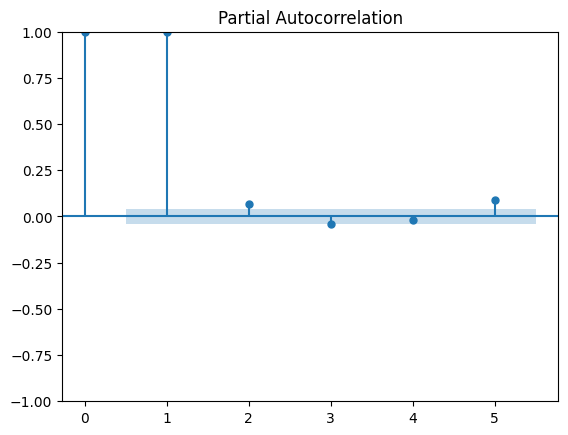

In [150]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=5)
plt.show()

In [151]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [152]:
# Chia thành các tập train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [153]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [154]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 2
n_features = 1

In [155]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [156]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [157]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
47/47 - 4s - loss: 0.0353 - val_loss: 0.0047 - 4s/epoch - 89ms/step
Epoch 2/50
47/47 - 0s - loss: 0.0021 - val_loss: 0.0012 - 288ms/epoch - 6ms/step
Epoch 3/50
47/47 - 0s - loss: 5.7053e-04 - val_loss: 0.0013 - 305ms/epoch - 6ms/step
Epoch 4/50
47/47 - 0s - loss: 5.4895e-04 - val_loss: 0.0013 - 260ms/epoch - 6ms/step
Epoch 5/50
47/47 - 0s - loss: 5.4099e-04 - val_loss: 0.0012 - 279ms/epoch - 6ms/step
Epoch 6/50
47/47 - 0s - loss: 5.0470e-04 - val_loss: 0.0012 - 233ms/epoch - 5ms/step
Epoch 7/50
47/47 - 0s - loss: 4.9171e-04 - val_loss: 0.0012 - 236ms/epoch - 5ms/step
Epoch 8/50
47/47 - 0s - loss: 4.9329e-04 - val_loss: 0.0013 - 227ms/epoch - 5ms/step
Epoch 9/50
47/47 - 0s - loss: 4.7988e-04 - val_loss: 0.0013 - 225ms/epoch - 5ms/step
Epoch 10/50
47/47 - 0s - loss: 4.9069e-04 - val_loss: 0.0013 - 222ms/epoch - 5ms/step
Epoch 11/50
47/47 - 0s - loss: 4.7253e-04 - val_loss: 0.0012 - 225ms/epoch - 5ms/step
Epoch 12/50
47/47 - 0s - loss: 4.6571e-04 - val_loss: 0.0011 - 226ms/epoc

In [158]:
# Dự đoán trên 2 tập X_test và X_val
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [159]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.029774062034911536
Testing RMSE: 0.041170254356307015
Testing MAE: 0.03409394236874167
Validation MAE: 0.02306965413407639
Testing MAPE: 4.691386905672662
Validation MAPE: 5.2632251538965775


In [160]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [161]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [162]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


In [163]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

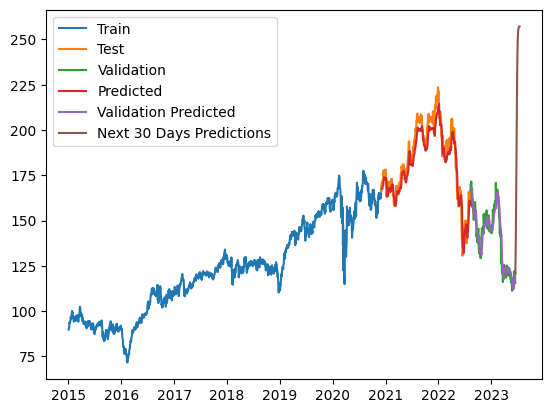

In [164]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>2. Data ARI-Historical-Data-final

In [165]:
# Import data
df = pd.read_csv('ARI-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df1=df.reset_index()['Price']

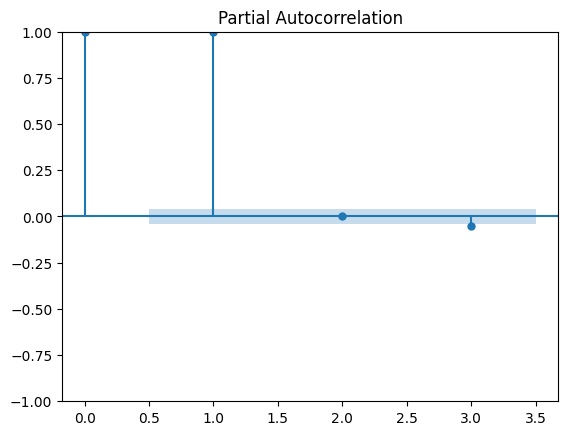

In [166]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=3)
plt.show()

In [167]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [168]:
# Chia thành các tập train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [169]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [170]:
# Chọn các giá trị lookback, horizon, n_features
lookback = 3
horizon = 1
n_features = 1

In [171]:
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [172]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [173]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
47/47 - 4s - loss: 0.2013 - val_loss: 0.0092 - 4s/epoch - 77ms/step
Epoch 2/50
47/47 - 0s - loss: 0.0052 - val_loss: 0.0139 - 219ms/epoch - 5ms/step
Epoch 3/50
47/47 - 0s - loss: 0.0031 - val_loss: 0.0087 - 215ms/epoch - 5ms/step
Epoch 4/50
47/47 - 0s - loss: 0.0021 - val_loss: 0.0049 - 206ms/epoch - 4ms/step
Epoch 5/50
47/47 - 0s - loss: 0.0014 - val_loss: 0.0024 - 208ms/epoch - 4ms/step
Epoch 6/50
47/47 - 0s - loss: 9.7918e-04 - val_loss: 0.0013 - 216ms/epoch - 5ms/step
Epoch 7/50
47/47 - 0s - loss: 7.8009e-04 - val_loss: 8.6627e-04 - 217ms/epoch - 5ms/step
Epoch 8/50
47/47 - 0s - loss: 7.0311e-04 - val_loss: 7.0630e-04 - 215ms/epoch - 5ms/step
Epoch 9/50
47/47 - 0s - loss: 6.7710e-04 - val_loss: 7.0163e-04 - 233ms/epoch - 5ms/step
Epoch 10/50
47/47 - 0s - loss: 6.7030e-04 - val_loss: 6.9955e-04 - 283ms/epoch - 6ms/step
Epoch 11/50
47/47 - 0s - loss: 6.6848e-04 - val_loss: 7.1153e-04 - 278ms/epoch - 6ms/step
Epoch 12/50
47/47 - 0s - loss: 6.6854e-04 - val_loss: 7.1037e-04 

In [174]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [175]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.025703133795084647
Testing RMSE: 0.022121023803367442
Testing MAE: 0.01739850570004644
Validation MAE: 0.018941745172621736
Testing MAPE: 3.026564338254069
Validation MAPE: 4.713640457989376


In [176]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [177]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [178]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 17ms/step


In [179]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

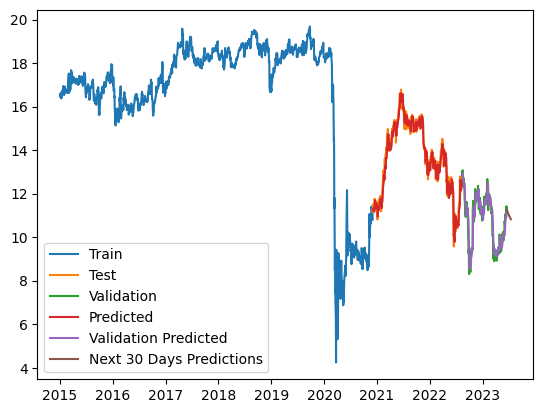

In [180]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>3. Data MAA-Historical-Data-final

In [181]:
# Import data
df = pd.read_csv('MAA-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df2=df.reset_index()['Price']

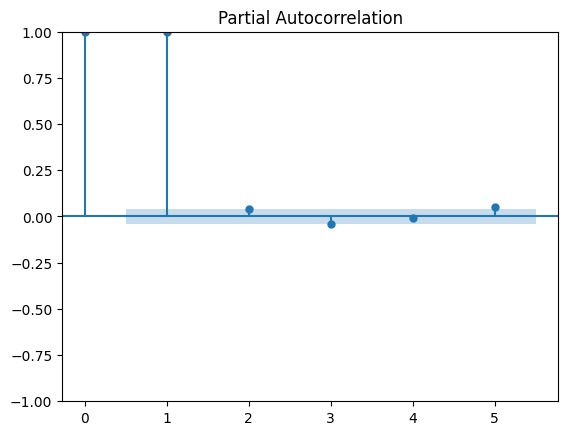

In [182]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df2, lags=5)
plt.show()

In [183]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [184]:
# Chia thành các tập train, test, validation
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [185]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [186]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 2
n_features = 1

In [187]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [188]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [189]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
47/47 - 5s - loss: 0.1575 - val_loss: 0.0077 - 5s/epoch - 97ms/step
Epoch 2/50
47/47 - 0s - loss: 0.0039 - val_loss: 0.0095 - 282ms/epoch - 6ms/step
Epoch 3/50
47/47 - 0s - loss: 0.0024 - val_loss: 0.0047 - 269ms/epoch - 6ms/step
Epoch 4/50
47/47 - 0s - loss: 0.0017 - val_loss: 0.0025 - 270ms/epoch - 6ms/step
Epoch 5/50
47/47 - 0s - loss: 0.0014 - val_loss: 0.0016 - 261ms/epoch - 6ms/step
Epoch 6/50
47/47 - 0s - loss: 0.0012 - val_loss: 0.0013 - 271ms/epoch - 6ms/step
Epoch 7/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0012 - 256ms/epoch - 5ms/step
Epoch 8/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0012 - 258ms/epoch - 5ms/step
Epoch 9/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0012 - 265ms/epoch - 6ms/step
Epoch 10/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0012 - 305ms/epoch - 6ms/step
Epoch 11/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0012 - 295ms/epoch - 6ms/step
Epoch 12/50
47/47 - 0s - loss: 0.0011 - val_loss: 0.0012 - 297ms/epoch - 6ms/step
Epoch 13/50
47/47 - 0s - lo

In [190]:

y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [191]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.03302919305123011
Testing RMSE: 0.02844594955761792
Testing MAE: 0.02238189060131946
Validation MAE: 0.02391929827866599
Testing MAPE: 3.886304433642563
Validation MAPE: 5.898256820654268


In [192]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [193]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [194]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


In [195]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

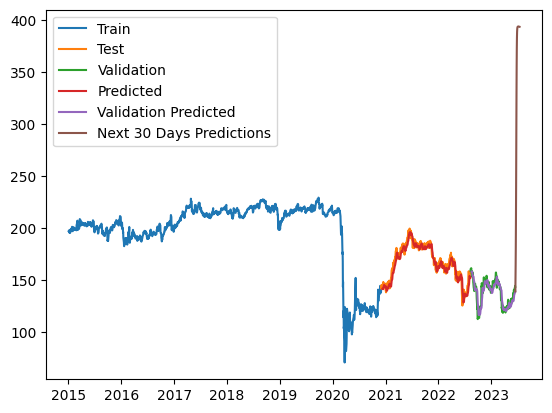

In [196]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()